#v7: load saved data (cross-valid), data cleaning, y_noisy no obey rules

#airplane : 0 automobile : 1 bird : 2 cat : 3 deer : 4 dog : 5 frog : 6 horse : 7 ship : 8 truck : 9

hqua chạy xong cái 399% cho normal, bắt đầu đến cell rough. còn case 30% của normal chưa load đc vì lỗi, chạy xong hết r

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
noise_level_str='5002'
i_run_list=[0]
is_colab=1
run_normal=1
run_LossCorrection=1
run_Rule=1
epochs_plot=30
epochs_rough=28
is_train_rough=1
N=0.401
is_defined_T=0
num_folds=3
rule_code='rule14' # rule12 ='' ; rule 124='rule124'

In [2]:
if is_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    work_path='/content/gdrive/MyDrive/Drive nguyendinhquoc312/LAB/Nakajo_labelNoise/code/cifar10/'
else:
    work_path='/home/nakajolab1/code_labelnoise_tomo/cifar10/'
checkpoint_filepath = work_path+'resnet_proposedAlgo/output/tmp_model/'
import os
os.chdir(checkpoint_filepath)
# 4/1AY0e-g5jtrlJIFkL_uN_atOzBiYSjiPg4Wuk4HtMRm4HW5ZLWQP8ceEcy7w

Mounted at /content/gdrive


#import

In [14]:
if noise_level_str=='01': #manipulated rough
    acc_well_model='100'
    trainAcc_rough='849'
    testAcc_rough='832'
if noise_level_str=='02': #manipulated rough
    acc_well_model='100'
    trainAcc_rough='875'
    testAcc_rough='844'
if noise_level_str=='1001':
    acc_well_model='874_839'
    trainAcc_rough='798'
    testAcc_rough='792'
if noise_level_str=='2001':
    acc_well_model='788_766'
    trainAcc_rough='785'
    testAcc_rough='777'
if noise_level_str=='2002':#789_78
    acc_well_model='788_766'
    trainAcc_rough='789'
    testAcc_rough='78'
if noise_level_str=='3001':#793_662 verified y_train_noisy
    acc_well_model='689_678'
    trainAcc_rough='793'
    testAcc_rough='662'
if noise_level_str=='3002':
    acc_well_model='689_678'
    trainAcc_rough='819'
    testAcc_rough='675'
if noise_level_str=='3003':
    acc_well_model='689_678'
    trainAcc_rough=''
    testAcc_rough=''
if noise_level_str=='4001':#  240321_verified y_train_noisy
    acc_well_model='449'
    trainAcc_rough='763'
    testAcc_rough='583'
if noise_level_str=='4002':#  240321_verified y_train_noisy
    acc_well_model='449'
    trainAcc_rough='591'
    testAcc_rough='583'
if noise_level_str=='4003':
    acc_well_model='449'
    trainAcc_rough=''
    testAcc_rough=''
if noise_level_str=='5001':#verified y_train_noisy
    acc_well_model='486'
    trainAcc_rough='772'
    testAcc_rough='472'
if noise_level_str=='5002':#verified y_train_noisy
    acc_well_model='486'
    trainAcc_rough='776'
    testAcc_rough='433'
if noise_level_str=='5003':#verified y_train_noisy
    acc_well_model='486'
    trainAcc_rough=''
    testAcc_rough=''
elif noise_level_str=='101':
    acc_well_model='874_839'
    trainAcc_rough='793'
    testAcc_rough='769'
elif noise_level_str=='199':
    acc_well_model='788_766'
    trainAcc_rough='705'
    testAcc_rough='684'
elif noise_level_str=='301':
    acc_well_model='689_678'
    trainAcc_rough='672'
    testAcc_rough='666'
elif noise_level_str=='399':
    acc_well_model='56_552'
    trainAcc_rough='552'
    testAcc_rough='539'
elif noise_level_str=='501':
    acc_well_model='475'
    trainAcc_rough='505'
    testAcc_rough='502'
else:
    print('error')
if is_defined_T:
    acc_well_model=''
    trainAcc_rough=''
    testAcc_rough=''

error


In [5]:
import os

"""Trains a ResNet on the CIFAR10 dataset.
ResNet v1: [a] Deep Residual Learning for Image Recognition
https://arxiv.org/pdf/1512.03385.pdf
refer: https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py
"""
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.model_selection import KFold
kfold = KFold(n_splits=num_folds, shuffle=True)

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import keras.backend as K
import numpy as np
import os
import math

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
lr_reducer_novalid = ReduceLROnPlateau(monitor='loss',factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

##import LossCorrection

###model

In [6]:
class NoiseEstimator():

    def __init__(self, classifier, row_normalize=True, alpha=0.0,
                 filter_outlier=False, cliptozero=False, verbose=0):
        """classifier: an ALREADY TRAINED model. In the ideal case, classifier
        should be powerful enough to only make mistakes due to label noise."""

        self.classifier = classifier
        self.row_normalize = row_normalize
        self.alpha = alpha
        self.filter_outlier = filter_outlier
        self.cliptozero = cliptozero
        self.verbose = verbose

    def fit(self, X):

        # number of classes
        c = self.classifier.classes
        T = np.empty((c, c))

        # predict probability on the fresh sample
        eta_corr = self.classifier.model.predict(X)

        # find a 'perfect example' for each class
        for i in np.arange(c):

            if not self.filter_outlier:
                idx_best = np.argmax(eta_corr[:, i])
            else:
                eta_thresh = np.percentile(eta_corr[:, i], 97,
                                           interpolation='higher')
                robust_eta = eta_corr[:, i]
                robust_eta[robust_eta >= eta_thresh] = 0.0
                idx_best = np.argmax(robust_eta)

            for j in np.arange(c):
                T[i, j] = eta_corr[idx_best, j]

        self.T = T
        return self

    def predict(self):

        T = self.T
        c = self.classifier.classes

        if self.cliptozero:
            idx = np.array(T < 10 ** -6)
            T[idx] = 0.0

        if self.row_normalize:
            row_sums = T.sum(axis=1)
            T /= row_sums[:, np.newaxis]

        if self.verbose > 0:
            print(T)

        if self.alpha > 0.0:
            T = self.alpha * np.eye(c) + (1.0 - self.alpha) * T

        if self.verbose > 0:
            print(T)
            print(np.linalg.inv(T))

        return T


###loss

In [7]:
import numpy as np

from keras import backend as K

def crossentropy(y_true, y_pred):
    # this gives the same result as using keras.objective.crossentropy
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    return -K.sum(y_true * K.log(y_pred), axis=-1)


def robust(name, P):

    if name == 'backward':
        P_inv = K.constant(np.linalg.inv(P))

        def loss(y_true, y_pred):
            y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
            y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
            return -K.sum(K.dot(y_true, P_inv) * K.log(y_pred), axis=-1)

    elif name == 'forward':
        P = K.constant(P)

        def loss(y_true, y_pred):
            y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
            y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
            return -K.sum(y_true * K.log(K.dot(y_pred, P)), axis=-1)

    return loss


def unhinged(y_true, y_pred):
    return K.mean(1. - y_true * y_pred, axis=-1)


def sigmoid(y_true, y_pred):
    beta = 1.0
    return K.mean(K.sigmoid(-beta * y_true * y_pred), axis=-1)


def ramp(y_true, y_pred):
    beta = 1.0
    return K.mean(K.minimum(1., K.maximum(0., 1. - beta * y_true * y_pred)),
                  axis=-1)


def savage(y_true, y_pred):
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    return K.mean(1. / K.square(1. + K.exp(2 * y_true * y_pred)),
                  axis=-1)


def boot_soft(y_true, y_pred):
    beta = 0.95

    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    return -K.sum((beta * y_true + (1. - beta) * y_pred) *
                  K.log(y_pred), axis=-1)
def make_loss(loss, P=None):

    if loss == 'crossentropy':
        return crossentropy
    elif loss in ['forward', 'backward']:
        return robust(loss, P)
    elif loss == 'unhinged':
        return unhinged
    elif loss == 'sigmoid':
        return sigmoid
    elif loss == 'ramp':
        return ramp
    elif loss == 'savage':
        return savage
    elif loss == 'boot_soft':
        return boot_soft
    else:
        ValueError("Loss unknown.")

###noise

In [8]:
import numpy as np
from numpy.testing import assert_array_almost_equal


def unbiased_edge(x, y, p_minus, p_plus):
    z = (y - (p_minus - p_plus)) * x
    return z / (1 - p_minus - p_plus)


def unbiased_mean_op(X, y, p_minus, p_plus):
    return np.array([unbiased_edge(X[i, :], y[i], p_minus, p_plus)
                    for i in np.arange(X.shape[0])]).mean(axis=0)


def build_uniform_P(size, noise):
    """ The noise matrix flips any class to any other with probability
    noise / (#class - 1).
    """

    assert(noise >= 0.) and (noise <= 1.)

    P = noise / (size - 1) * np.ones((size, size))
    np.fill_diagonal(P, (1 - noise) * np.ones(size))

    assert_array_almost_equal(P.sum(axis=1), 1, 1)
    return P


def build_for_cifar100(size, noise):
    """ The noise matrix flips to the "next" class with probability 'noise'.
    """

    assert(noise >= 0.) and (noise <= 1.)

    P = (1. - noise) * np.eye(size)
    for i in np.arange(size - 1):
        P[i, i+1] = noise

    # adjust last row
    P[size-1, 0] = noise

    assert_array_almost_equal(P.sum(axis=1), 1, 1)
    return P


def row_normalize_P(P, copy=True):

    if copy:
        P_norm = P.copy()
    else:
        P_norm = P

    D = np.sum(P, axis=1)
    for i in np.arange(P_norm.shape[0]):
        P_norm[i, :] /= D[i]
    return P_norm


def noisify(y, p_minus, p_plus=None, random_state=0):
    """ Flip labels with probability p_minus.
    If p_plus is given too, the function flips with asymmetric probability.
    """

    assert np.all(np.abs(y) == 1)

    m = y.shape[0]
    new_y = y.copy()
    coin = np.random.RandomState(random_state)

    if p_plus is None:
        p_plus = p_minus

    # This can be made much faster by tossing all the coins and completely
    # avoiding the loop. Although, it is not simple to write the asymmetric
    # case then.
    for idx in np.arange(m):
        if y[idx] == -1:
            if coin.binomial(n=1, p=p_minus, size=1) == 1:
                new_y[idx] = -new_y[idx]
        else:
            if coin.binomial(n=1, p=p_plus, size=1) == 1:
                new_y[idx] = -new_y[idx]

    return new_y


def multiclass_noisify(y, P, random_state=0):
    """ Flip classes according to transition probability matrix T.
    It expects a number between 0 and the number of classes - 1.
    """

    assert P.shape[0] == P.shape[1]
    assert np.max(y) < P.shape[0]

    # row stochastic matrix
    assert_array_almost_equal(P.sum(axis=1), np.ones(P.shape[1]))
    assert (P >= 0.0).all()

    m = y.shape[0]
    new_y = y.copy()
    flipper = np.random.RandomState(random_state)

    for idx in np.arange(m):
        i = y[idx]
        # draw a vector with only an 1
        flipped = flipper.multinomial(1, P[i, :], 1)[0]
        new_y[idx] = np.where(flipped == 1)[0]

    return new_y


def noisify_with_P(y_train, nb_classes, noise, random_state=None):

    if noise > 0.0:
        P = build_uniform_P(nb_classes, noise)
        # seed the random numbers with #run
        y_train_noisy = multiclass_noisify(y_train, P=P,
                                           random_state=random_state)
        actual_noise = (y_train_noisy != y_train).mean()
        assert actual_noise > 0.0
        print('Actual noise %.2f' % actual_noise)
        y_train = y_train_noisy
    else:
        P = np.eye(nb_classes)

    return y_train, P


def noisify_mnist_asymmetric(y_train, noise, random_state=None):
    """mistakes:
        1 <- 7
        2 -> 7
        3 -> 8
        5 <-> 6
    """
    nb_classes = 10
    P = np.eye(nb_classes)
    n = noise

    if n > 0.0:
        # 1 <- 7
        P[7, 7], P[7, 1] = 1. - n, n

        # 2 -> 7
        P[2, 2], P[2, 7] = 1. - n, n

        # 5 <-> 6
        P[5, 5], P[5, 6] = 1. - n, n
        P[6, 6], P[6, 5] = 1. - n, n

        # 3 -> 8
        P[3, 3], P[3, 8] = 1. - n, n

        y_train_noisy = multiclass_noisify(y_train, P=P,
                                           random_state=random_state)
        actual_noise = (y_train_noisy != y_train).mean()
        assert actual_noise > 0.0
        print('Actual noise %.2f' % actual_noise)
        y_train = y_train_noisy

    return y_train, P


def noisify_cifar10_asymmetric(y_train, noise, random_state=None):
    """mistakes:
        automobile <- truck
        bird -> airplane
        cat <-> dog
        deer -> horse
    """
    nb_classes = 10
    P = np.eye(nb_classes)
    n = noise

    if n > 0.0:
        # automobile <- truck
        P[9, 9], P[9, 1] = 1. - n, n

        # bird -> airplane
        P[2, 2], P[2, 0] = 1. - n, n

        # cat <-> dog
        P[3, 3], P[3, 5] = 1. - n, n
        P[5, 5], P[5, 3] = 1. - n, n

        # automobile -> truck
        P[4, 4], P[4, 7] = 1. - n, n

        y_train_noisy = multiclass_noisify(y_train, P=P,
                                           random_state=random_state)
        actual_noise = (y_train_noisy != y_train).mean()
        assert actual_noise > 0.0
        print('Actual noise %.2f' % actual_noise)
        y_train = y_train_noisy

    return y_train, P


def noisify_cifar100_asymmetric(y_train, noise, random_state=None):
    """mistakes are inside the same superclass of 10 classes, e.g. 'fish'
    """
    nb_classes = 100
    P = np.eye(nb_classes)
    n = noise
    nb_superclasses = 20
    nb_subclasses = 5

    if n > 0.0:
        for i in np.arange(nb_superclasses):
            init, end = i * nb_subclasses, (i+1) * nb_subclasses
            P[init:end, init:end] = build_for_cifar100(nb_subclasses, n)

        y_train_noisy = multiclass_noisify(y_train, P=P,
                                           random_state=random_state)
        actual_noise = (y_train_noisy != y_train).mean()
        assert actual_noise > 0.0
        print('Actual noise %.2f' % actual_noise)
        y_train = y_train_noisy

    return y_train, P


def noisify_binary_asymmetric(y_train, noise, random_state=None):
    """mistakes:
        1 -> 0: n
        0 -> 1: .05
    """
    P = np.eye(2)
    n = noise

    assert 0.0 <= n < 0.5

    if noise > 0.0:
        P[1, 1], P[1, 0] = 1.0 - n, n
        P[0, 0], P[0, 1] = 0.95, 0.05

        y_train_noisy = multiclass_noisify(y_train, P=P,
                                           random_state=random_state)
        actual_noise = (y_train_noisy != y_train).mean()
        assert actual_noise > 0.0
        print('Actual noise %.2f' % actual_noise)
        y_train = y_train_noisy

    return y_train, P


##our import

In [9]:
list_class=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
def mergeDict(dict1, dict2):
   ''' Merge dictionaries and keep values of common keys in list'''
   dict3 = {**dict1, **dict2}
   for key, value in dict3.items():
       if key in dict1 and key in dict2:
               #dict3[key] = [value , dict1[key]]
               dict3[key] = value + dict1[key]
   return dict3
   
class saveRoughModelCallBacks(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None,):
        if epoch==epochs_rough:
            scores = self.model.evaluate(x_train,y_train_noisy,batch_size=128)
            global trainAcc_rough
            global testAcc_rough
            trainAcc_rough =str(np.round(scores[1],3))[2:5]
            scores = self.model.evaluate(x_test,y_test,batch_size=128)
            testAcc_rough=str(np.round(scores[1],3))[2:5]
            roughModel_weight_name=roughModel_path+'/roughModel_'+trainAcc_rough+'_'+testAcc_rough            
            self.model.save_weights(roughModel_weight_name)

class saveModelEpochAcc(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None,):
        filename=checkpoint_filepath+str(logs['accuracy'])[2:5]
        if (os.path.exists(filename)==False):
            os.mkdir(filename) 
            self.model.save_weights(filename+'/weight')   
class cifar10resnetQ():
    def __init__(self, depth=2,batch_size=32,epochs=45):
        self.batch_size = batch_size
        self.classes = 10
        self.input_shape = (32,32,3)
        self.epochs = epochs
        self.augmentation = True
        self.depth=depth
        self.model=self.build_model()

    def build_model(self):
        model = resnet_v1(input_shape=input_shape, depth=depth)

        model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3),metrics=['accuracy'])
        return model
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          xlabel='Predicted label',
                          ylabel='True label',
                          cmap=plt.cm.Blues):

  plt.figure(figsize=(9,5))
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  if cm.dtype == 'float':
      fmt = '.2f'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.show()

In [10]:
#airplane : 0 automobile : 1 bird : 2 cat : 3 deer : 4 dog : 5 frog : 6 horse : 7 ship : 8 truck : 9
def is_obey_is_vehicle_sample(label,is_vehicle):
    if (is_vehicle==True):
        return True if ((label ==0)|(label ==1)|(label ==8)|(label ==9)) else False
    else:
        return False if ((label ==0)|(label ==1)|(label ==8)|(label ==9)) else True
def is_obey_is_fly_sample(label,is_fly):
    if (is_fly==True):
        return True if ((label ==0)|(label ==2)) else False
    else:
        return False if ((label ==0)|(label ==2)) else True
#
def is_obey_is_onroad_sample(label,is_onroad):
    if (is_onroad==True):
        return True if ((label ==1)|(label ==9)) else False
    else:
        return False if ((label ==1)|(label ==9)) else True
def is_obey_is_mammal_sample(label,is_mammal):
    if (is_mammal==True):
        return True if ((label ==3)|(label ==4)|(label ==5)|(label ==7)) else False
    else:
        return False if ((label ==3)|(label ==4)|(label ==5)|(label ==7)) else True
def is_obey_is_vehicle_vector(y,is_vehicle):
    """
    input: shape (N,). The i^th element is class (2,4...)
    """
    for i in range(y.shape[0]):
        if (is_obey_is_vehicle_sample(y[i],is_vehicle[i])==False):
            print('violated vehicle rule at sample:',i)
            return False
    return True
def is_obey_is_fly_vector(y,is_fly):
    """
    input: shape (N,). The i^th element is class (2,4...)
    """
    for i in range(y.shape[0]):
        if (is_obey_is_fly_sample(y[i],is_fly[i])==False):
            print('violated fly rule at sample:',i)
            return False
    return True
def is_obey_is_onroad_vector(y,is_onroad):
    """
    input: shape (N,). The i^th element is class (2,4...)
    """
    for i in range(y.shape[0]):
        if (is_obey_is_onroad_sample(y[i],is_onroad[i])==False):
            print('violated onroad rule at sample:',i)
            return False
    return True
def RuleCheck_YtLabelt(idx_mb): #only fed idx make this func run faster
    """
    input: shape (mb_size,). The index which we want to check rules
    return Dt is a list containt index of violated sample
    """
    
    diff=(Yt!=Label_t)
    rule1=list(map(is_obey_is_vehicle_sample,Yt,is_vehicle[idx_mb]))
    rule2=list(map(is_obey_is_fly_sample,Yt,is_fly[idx_mb]))
    rule3=list(map(is_obey_is_onroad_sample,Yt,is_onroad[idx_mb]))
    D=np.arange(idx_mb.shape[0])
    violated_rule= ~ (np.array(rule1) & np.array(rule2)& np.array(rule3))
    return D[diff & violated_rule]
def RuleCheck_YtLabelt_whole(whole_Yt): #only fed idx make this func run faster
    """
    input: shape (mb_size,). The index which we want to check rules
    return Dt is a list containt index of violated sample
    """
    
    diff=(whole_Yt==y_train_noisy_raw)
    print('number of correct prediction:',np.count_nonzero(diff))
    rule1=list(map(is_obey_is_vehicle_sample,whole_Yt,is_vehicle))
    #rule2=list(map(is_obey_is_fly_sample,whole_Yt,is_fly))
    #rule3=list(map(is_obey_is_onroad_sample,whole_Yt,is_onroad))
    rule4=list(map(is_obey_is_mammal_sample,whole_Yt,is_mammal))
    #violated_rule= ~ (np.array(rule1) & np.array(rule2)& np.array(rule4))
    violated_rule= ~ (np.array(rule1) & np.array(rule4))
    #violated_rule= ~ (np.array(rule1))
    print('number violated samples:',np.count_nonzero(violated_rule))
    whole_Dt=np.arange(whole_Yt.shape[0])*(diff & violated_rule)
    print('number of detected label noise: ',np.shape(np.nonzero(whole_Dt)[0]))
    return whole_Dt

#my exp

##load cifar

In [11]:
# training parameters
batch_size = 32 # orig paper trained all networks with batch_size=128
epochs = 45
batch_size_modelt=32
data_augmentation = True
# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

n = 2 #n = 2 ResNet14 ; n = 5 ResNet32
version = 1
depth = n * 6 + 2
# computed depth from supplied model parameter n

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
# input image dimensions.
input_shape = (32,32,3)
n_train_samples=50000
t=np.load(checkpoint_filepath+'savez_data/full_preprocessed_img.npz',allow_pickle=True)
X,Y=t['arr_0'],t['arr_1']
t=np.load(checkpoint_filepath+'savez_data/levelNoise'+noise_level_str+'_acc_well'+acc_well_model+'.npz',allow_pickle=True)
idx_train, idx_test,y_train_noisy=t['arr_0'],t['arr_1'],t['arr_2']
x_train,x_test= X[idx_train],X[idx_test]
y_train_raw, y_test_raw =Y[idx_train],Y[idx_test]
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

# convert class vectors to binary class matrices.
y_train_1hot = to_categorical(y_train_raw, 10)
y_test_1hot = to_categorical(y_test_raw, 10)

# in manga, y_test is raw, in cifar, y_test is 1hot
y_test=y_test_1hot
y_train=y_train_1hot
"""
from sklearn.model_selection import train_test_split
x_train_train, x_val, y_train_train, y_val,idx_train,idx_val = train_test_split(x_train, y_train_raw,np.arange(n_train_samples), test_size=0.2, random_state=1)

unique, counts = np.unique(y_train_train, return_counts=True)
plt.bar(unique, counts)
unique, counts = np.unique(y_val, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()
y_val= to_categorical(y_val, 10)

datagen_validation = ImageDataGenerator(
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True)

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen_validation.fit(x_train_train)
"""
datagen = ImageDataGenerator(
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,)

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)
is_vehicle=np.array([((y_train_raw[y] ==0)|(y_train_raw[y] ==1)|(y_train_raw[y] ==8)|(y_train_raw[y] ==9)) for y in range(n_train_samples)])
is_fly=np.array([((y_train_raw[y] ==0)|(y_train_raw[y] ==2)) for y in range(n_train_samples)])
#is_onroad=np.array([((y_train_raw[y] ==1)|(y_train_raw[y] ==9)) for y in range(n_train_samples)])
is_mammal=np.array([((y_train_raw[y] ==3)|(y_train_raw[y] ==4)|(y_train_raw[y] ==5)|(y_train_raw[y] ==7)) for y in range(n_train_samples)])
#Q: still confusing about whether cifar10.load_data() shuffle ???
"""
if is_defined_T:
    y_train_noisy, P = noisify_with_P(y_train_raw, 10, N)
else:
    y_train_noisy=np.load(checkpoint_filepath+'y_train_noisy_resnet_3rule/'+noise_level_str+'by'+acc_well_model+'.npz',allow_pickle=True)['arr_0']
"""
y_train_noisy_raw=y_train_noisy
y_train_noisy_1hot = keras.utils.to_categorical(y_train_noisy, 10)
y_train_noisy=y_train_noisy_1hot
roughModel_path=checkpoint_filepath+'noiseLevel'+noise_level_str+'_testAcc'+acc_well_model

airplane : 0
automobile : 1
bird : 2
cat : 3
deer : 4
dog : 5
frog : 6
horse : 7
ship : 8
truck : 9

https://www.kaggle.com/spidy20/cifar-10-image-classification

#normal

In [ ]:
roughModel_path=checkpoint_filepath+'noiseLevel'+noise_level_str+'_testAcc'+acc_well_model
is_save_model=1
is_save_rough=1
epochs=epochs_plot
is_continue_normal=1

if run_normal:
    for i_run in i_run_list:
        idx_fold=1
        tf.random.set_seed(i_run)
        normalModel_path=checkpoint_filepath+'v7/noiseLevel'+noise_level_str+'normal_'+str(i_run)
        normal_history_name=roughModel_path+'/normal_history_'+str(i_run)
        
        normalModel = cifar10resnetQ()
        """
        if (os.path.exists(normalModel_path)&(is_continue_normal==1)):
            print('existed, loading') 
            normalModel.model.load_weights(normalModel_path+'/normalModel')
            t=np.load(normal_history_name+'.npz',allow_pickle=True)['arr_0']
            normal_history_pre=dict(t.flatten()[0])
            epochs=epochs_plot-len(normal_history_pre['val_accuracy'])
            epochs_rough=max(0,epochs_rough-len(normal_history_pre['val_accuracy']))
            print('continue at epochs',epochs)
        """

        if is_train_rough:
            normal_history = normalModel.model.fit(
                x=datagen.flow(x_train, y_train_noisy, batch_size=batch_size),
                #steps_per_epoch=n_train_samples // batch_size,
                callbacks=[saveRoughModelCallBacks()],
                epochs=epochs,verbose=1, validation_data=(x_test,y_test))
            normal_history_history=normal_history.history

            #np.savez(roughModel_path+'/rough_history',normal_history1.history)
        else:    
            normal_history = normalModel.model.fit(
                x=datagen.flow(x_train, y_train_noisy, batch_size=batch_size),
                #steps_per_epoch=n_train_samples // batch_size,
                validation_freq=1,#callbacks=[tf.keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True)],
                epochs=epochs,verbose=1, validation_data=(x_test,y_test))
            normal_history_history=normal_history.history

        if (is_save_model):
            np.savez(normal_history_name,normal_history_history)
            if (os.path.exists(checkpoint_filepath+'v7')==False):
                os.mkdir(checkpoint_filepath+'v7') 
            if (os.path.exists(normalModel_path)==False):
                os.mkdir(normalModel_path) 
            normalModel.model.save_weights(normalModel_path+'/normalModel')

Epoch 1/30
1563/1563 [==============================] - 66s 21ms/step - loss: 1.3594 - accuracy: 0.5721 - val_loss: 2.9640 - val_accuracy: 0.3192
Epoch 2/30
1563/1563 [==============================] - 32s 20ms/step - loss: 0.9409 - accuracy: 0.6996 - val_loss: 2.2845 - val_accuracy: 0.3927
Epoch 3/30
1563/1563 [==============================] - 31s 20ms/step - loss: 0.8802 - accuracy: 0.7189 - val_loss: 2.1363 - val_accuracy: 0.4241
Epoch 4/30
1563/1563 [==============================] - 32s 20ms/step - loss: 0.8541 - accuracy: 0.7300 - val_loss: 2.2436 - val_accuracy: 0.4308
Epoch 5/30
1563/1563 [==============================] - 31s 20ms/step - loss: 0.8288 - accuracy: 0.7331 - val_loss: 2.6584 - val_accuracy: 0.3860
Epoch 6/30
1563/1563 [==============================] - 32s 20ms/step - loss: 0.8128 - accuracy: 0.7394 - val_loss: 2.1012 - val_accuracy: 0.4534
Epoch 7/30
1563/1563 [==============================] - 31s 20ms/step - loss: 0.8040 - accuracy: 0.7406 - val_loss: 2.3173 -

In [ ]:
"""
i_run=0
normalModel_path=checkpoint_filepath+'v7/noiseLevel'+noise_level_str+'normal_'+str(i_run)
normalModel = cifar10resnetQ()
normalModel.model.load_weights(normalModel_path+'/normalModel')
normalModel.model.evaluate(x_train,y_train_noisy)
normalModel.model.evaluate(x_test,y_test)
roughModel.model.evaluate(x_train,y_train_noisy)
roughModel.model.evaluate(x_test,y_test)
roughModel_weight_name=roughModel_path+'/roughModel_785_777'            
normalModel.model.save_weights(roughModel_weight_name)
"""

"\ni_run=0\nnormalModel_path=checkpoint_filepath+'v7/noiseLevel'+noise_level_str+'normal_'+str(i_run)\nnormalModel = cifar10resnetQ()\nnormalModel.model.load_weights(normalModel_path+'/normalModel')\nnormalModel.model.evaluate(x_train,y_train_noisy)\nnormalModel.model.evaluate(x_test,y_test)\nroughModel.model.evaluate(x_train,y_train_noisy)\nroughModel.model.evaluate(x_test,y_test)\nroughModel_weight_name=roughModel_path+'/roughModel_785_777'            \nnormalModel.model.save_weights(roughModel_weight_name)\n"

#rough

In [15]:
roughModel = cifar10resnetQ()
roughModel_path=checkpoint_filepath+'noiseLevel'+noise_level_str+'_testAcc'+acc_well_model
roughModel_weight_name=roughModel_path+'/roughModel_'+trainAcc_rough+'_'+testAcc_rough            
roughModel.model.load_weights(roughModel_weight_name)

whole_Yt=roughModel.model.predict(x_train).argmax(axis=1)
whole_Label_t=y_train_noisy
whole_Dt=RuleCheck_YtLabelt_whole(whole_Yt)

number of correct prediction: 38814
number violated samples: 14144
number of detected label noise:  (9870,)


In [13]:
import glob
glob.glob(roughModel_path+'/*')

['/content/gdrive/MyDrive/Drive nguyendinhquoc312/LAB/Nakajo_labelNoise/code/cifar10/resnet_proposedAlgo/output/tmp_model/noiseLevel5002_testAcc486/roughModel_776_433.data-00000-of-00001',
 '/content/gdrive/MyDrive/Drive nguyendinhquoc312/LAB/Nakajo_labelNoise/code/cifar10/resnet_proposedAlgo/output/tmp_model/noiseLevel5002_testAcc486/roughModel_776_433.index',
 '/content/gdrive/MyDrive/Drive nguyendinhquoc312/LAB/Nakajo_labelNoise/code/cifar10/resnet_proposedAlgo/output/tmp_model/noiseLevel5002_testAcc486/dclean_0',
 '/content/gdrive/MyDrive/Drive nguyendinhquoc312/LAB/Nakajo_labelNoise/code/cifar10/resnet_proposedAlgo/output/tmp_model/noiseLevel5002_testAcc486/rule_remove_rule140.npz',
 '/content/gdrive/MyDrive/Drive nguyendinhquoc312/LAB/Nakajo_labelNoise/code/cifar10/resnet_proposedAlgo/output/tmp_model/noiseLevel5002_testAcc486/rule_remove_rule140',
 '/content/gdrive/MyDrive/Drive nguyendinhquoc312/LAB/Nakajo_labelNoise/code/cifar10/resnet_proposedAlgo/output/tmp_model/noiseLevel5

#Data Cleaning

In [ ]:
#270121 : start change to train on batch instead of fit because it isn't work


#not usually change
is_save_cleaning=1
epochs=epochs_plot
continu=1
run_dclean=1
is_save_dclean=1
if (run_dclean):

    for i_run in i_run_list:
        tf.random.set_seed(i_run)
        dclean_filename=roughModel_path+'/dclean_'+str(i_run)
        Model_t2 = cifar10resnetQ()
        
        if (os.path.exists(dclean_filename)&(continu==1)):
            t=np.load(dclean_filename+'.npz',allow_pickle=True)['arr_0']
            dclean_history_pre=dict(t.flatten()[0])
            epochs=epochs_plot-len(dclean_history_pre['val_accuracy'])
            print('epochs',epochs)
            Model_t2.model.load_weights(dclean_filename+'/dclean_tmp')
        else: #include case: avaiable model & force_run_again=1 & continu=0
            eps=np.ones(n_train_samples,dtype=int)
            dclean_history=[]

        idx_obey_samples=(whole_Yt==y_train_noisy_raw)
        x_train_obey_samples=x_train[idx_obey_samples]
        Label_t_obey_samples=y_train_noisy[idx_obey_samples]
        datagen.fit(x_train_obey_samples)
        
        dclean_history=Model_t2.model.fit(
            x=datagen.flow(x_train_obey_samples, Label_t_obey_samples, batch_size=batch_size_modelt),
            #if not use flow, the variance of result is too large
            #steps_per_epoch=50000 // batch_size,
            epochs=epochs,verbose=1,validation_data=(x_test,y_test))
        if (is_save_dclean):
            if (os.path.exists(dclean_filename)&(continu==1)):
                np.savez(dclean_filename,mergeDict(dclean_history_pre,dclean_history.history))
            else:
                np.savez(dclean_filename,dclean_history.history)
            if (os.path.exists(dclean_filename)==False):
                os.mkdir(dclean_filename)
            Model_t2.model.save_weights(dclean_filename+'/dclean_tmp')

Epoch 1/30
1097/1097 [==============================] - 24s 21ms/step - loss: 1.1675 - accuracy: 0.6381 - val_loss: 3.7154 - val_accuracy: 0.2851
Epoch 2/30
1097/1097 [==============================] - 22s 20ms/step - loss: 0.6261 - accuracy: 0.8099 - val_loss: 4.5995 - val_accuracy: 0.3224
Epoch 3/30
1097/1097 [==============================] - 22s 20ms/step - loss: 0.5394 - accuracy: 0.8393 - val_loss: 4.1556 - val_accuracy: 0.3572
Epoch 4/30
1097/1097 [==============================] - 22s 20ms/step - loss: 0.5144 - accuracy: 0.8483 - val_loss: 2.8869 - val_accuracy: 0.4491
Epoch 5/30
1097/1097 [==============================] - 22s 20ms/step - loss: 0.4774 - accuracy: 0.8614 - val_loss: 3.2280 - val_accuracy: 0.4103
Epoch 6/30
1097/1097 [==============================] - 23s 21ms/step - loss: 0.4608 - accuracy: 0.8671 - val_loss: 2.7527 - val_accuracy: 0.4723
Epoch 7/30
1097/1097 [==============================] - 23s 21ms/step - loss: 0.4564 - accuracy: 0.8673 - val_loss: 4.1758 -

#LossCorrection

In [ ]:
roughModel_path=checkpoint_filepath+'noiseLevel'+noise_level_str+'_testAcc'+acc_well_model

if run_LossCorrection:
    loss='forward'
    for is_est in [0,1]:
        for i_run in i_run_list:
            tf.random.set_seed(i_run)
            if (is_est):
                est = NoiseEstimator(classifier=roughModel, alpha=0.0,filter_outlier=True)
                P = est.fit(x_train).predict()
                lcModel_path=checkpoint_filepath+'v7/noiseLevel'+noise_level_str+'est_'+loss+str(i_run)
                lc_history_name=roughModel_path+'/LC_est_forward_history'+str(i_run)
            else:
                from sklearn.metrics import confusion_matrix
                P=confusion_matrix(y_train_raw, y_train_noisy_raw)
                #in cifar, don't need to normalize P, because the number of samples of each class is equal among 
                #classes, then when calculate loss, multipling it with a constant don't change gradient.
                lcModel_path=checkpoint_filepath+'v7/noiseLevel'+noise_level_str+'_'+loss+str(i_run)
                lc_history_name=roughModel_path+'/LC_forward_history'+str(i_run)


            lcModel = cifar10resnetQ()
            lcModel.model.compile(loss=make_loss(loss, P),
                                optimizer=Adam(lr=1e-3),metrics=['accuracy'])
            #callbacks = [tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]
            
            lc_history = lcModel.model.fit(
                x=datagen.flow(x_train, y_train_noisy_1hot, batch_size=batch_size),
                #steps_per_epoch=n_train_samples // batch_size,
                epochs=epochs_plot,verbose=1, validation_data=(x_test,y_test_1hot))
            np.savez(lc_history_name,lc_history.history)
            if (os.path.exists(lcModel_path)==False):
                os.mkdir(lcModel_path) 
            lcModel.model.save_weights(lcModel_path+'/lcModel')
"""
lc_history = lcModel.model.fit(
    x=datagen_validation.flow(x_train, y_train_noisy_1hot, batch_size=batch_size,subset='training'),
    #steps_per_epoch=n_train_samples // batch_size,
    epochs=90,verbose=2,
    validation_data=datagen_validation.flow(x_train, y_train_noisy_1hot, batch_size=batch_size,subset='validation'),
    callbacks=callbacks)
    """

Epoch 1/30
1563/1563 [==============================] - 34s 21ms/step - loss: -7.0550 - accuracy: 0.2899 - val_loss: -5.9509 - val_accuracy: 0.3917
Epoch 2/30
1563/1563 [==============================] - 32s 21ms/step - loss: -7.3537 - accuracy: 0.4166 - val_loss: -6.1217 - val_accuracy: 0.4418
Epoch 3/30
1563/1563 [==============================] - 33s 21ms/step - loss: -7.4034 - accuracy: 0.4399 - val_loss: -6.1700 - val_accuracy: 0.4407
Epoch 4/30
1563/1563 [==============================] - 33s 21ms/step - loss: -7.4209 - accuracy: 0.4399 - val_loss: -6.2115 - val_accuracy: 0.4539
Epoch 5/30
1563/1563 [==============================] - 33s 21ms/step - loss: -7.4353 - accuracy: 0.4461 - val_loss: -6.3358 - val_accuracy: 0.4709
Epoch 6/30
1563/1563 [==============================] - 32s 21ms/step - loss: -7.4460 - accuracy: 0.4483 - val_loss: -6.5664 - val_accuracy: 0.5309
Epoch 7/30
1563/1563 [==============================] - 32s 21ms/step - loss: -7.4708 - accuracy: 0.4554 - val_l

"\nlc_history = lcModel.model.fit(\n    x=datagen_validation.flow(x_train, y_train_noisy_1hot, batch_size=batch_size,subset='training'),\n    #steps_per_epoch=n_train_samples // batch_size,\n    epochs=90,verbose=2,\n    validation_data=datagen_validation.flow(x_train, y_train_noisy_1hot, batch_size=batch_size,subset='validation'),\n    callbacks=callbacks)\n    "

#core algo

##Rule_remove

In [ ]:
#270121 : start change to train on batch instead of fit because it isn't work
if (run_Rule):
    continu=1
    epochs=epochs_plot
    for i_run in i_run_list:
        tf.random.set_seed(i_run)
        rule_remove_filename=roughModel_path+'/rule_remove_'+rule_code+str(i_run)
        Model_t2 = cifar10resnetQ()
        #Model_t2.model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3),metrics=['accuracy'])

        if (os.path.exists(rule_remove_filename)&(continu==1)):
            t=np.load(rule_remove_filename+'.npz',allow_pickle=True)['arr_0']
            rule_remove_history_pre=dict(t.flatten()[0])
            epochs=epochs_plot-len(rule_remove_history_pre['val_accuracy'])
            print('epochs',epochs)
            Model_t2.model.load_weights(rule_remove_filename+'/rule_remove_tmp')
        else: #include case: avaiable model & force_run_again=1 & continu=0
            eps=np.ones(n_train_samples,dtype=int)
            rule_remove_history=[]

        Dt=np.nonzero(whole_Dt)[0]#a mask(t=1 inplace of violated sample)
        
        eps[Dt]=0
        idx_obey_samples=np.nonzero(eps)[0]
        x_train_obey_samples=x_train[idx_obey_samples]
        Label_t_obey_samples=whole_Label_t[idx_obey_samples]
        datagen.fit(x_train_obey_samples)
        rule_remove_history=Model_t2.model.fit(
            x=datagen.flow(x_train_obey_samples, Label_t_obey_samples, batch_size=batch_size_modelt),
            #steps_per_epoch=n_train_samples // batch_size,
            epochs=epochs,verbose=1,validation_data=(x_test,y_test_1hot))

        if (os.path.exists(rule_remove_filename)&(continu==1)):
            np.savez(rule_remove_filename,mergeDict(rule_remove_history_pre,rule_remove_history.history))
        else:
            np.savez(rule_remove_filename,rule_remove_history.history)
        if (os.path.exists(rule_remove_filename)==False):
            os.mkdir(rule_remove_filename)
        Model_t2.model.save_weights(rule_remove_filename+'/rule_remove_tmp')

Epoch 1/30
1318/1318 [==============================] - 29s 21ms/step - loss: 1.4340 - accuracy: 0.5469 - val_loss: 3.0054 - val_accuracy: 0.3116
Epoch 2/30
1318/1318 [==============================] - 27s 20ms/step - loss: 0.9737 - accuracy: 0.6857 - val_loss: 1.9830 - val_accuracy: 0.4614
Epoch 3/30
1318/1318 [==============================] - 27s 20ms/step - loss: 0.9167 - accuracy: 0.7055 - val_loss: 3.4393 - val_accuracy: 0.3483
Epoch 4/30
1318/1318 [==============================] - 27s 20ms/step - loss: 0.9003 - accuracy: 0.7110 - val_loss: 2.1243 - val_accuracy: 0.4489
Epoch 5/30
1318/1318 [==============================] - 27s 20ms/step - loss: 0.8713 - accuracy: 0.7193 - val_loss: 2.3849 - val_accuracy: 0.3999
Epoch 6/30
1318/1318 [==============================] - 27s 20ms/step - loss: 0.8513 - accuracy: 0.7269 - val_loss: 2.0762 - val_accuracy: 0.4515
Epoch 7/30
1318/1318 [==============================] - 27s 20ms/step - loss: 0.8312 - accuracy: 0.7340 - val_loss: 2.0993 -

In [ ]:
dang chay do

##Rule_weight

In [16]:
#270121 : start change to train on batch instead of fit because it isn't work

if (run_Rule):
    continu=1
    is_save=1
    #for lr_w in [0.02,0.1,0.4]:
    #    for n_batch_modelt in n_batch_modelt_list:  #n_batch_modelt_list=[50]#[50,150,250]
    for (lr_w,n_batch_modelt) in [(0.4,50),(0.1,50),(0.4,50)]:#[(0.02,50),(0.1,50),(0.4,50),(0.1,150),(0.1,250)]
        for i_run in i_run_list:
            tf.random.set_seed(i_run)
            epochs=epochs_plot
            rule_weight_filename=roughModel_path+'/rule_weight_lr_w'+str(lr_w)+'_n_batch_modelt'+str(n_batch_modelt)+rule_code+'_'+str(i_run)

            print(str(lr_w)+'_'+str(n_batch_modelt))
            Model_t = cifar10resnetQ()
            #Model_t.model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3),metrics=['accuracy'])
            
            if (os.path.exists(rule_weight_filename)&(continu==1)):
                d=np.load(rule_weight_filename+'history.npz',allow_pickle=True)
                eps,val_history=d['arr_0'],d['arr_1'].tolist()
                print(len(val_history))
                Model_t.model.load_weights(rule_weight_filename+'/rule_weight_tmp')
                epochs=epochs-len(val_history)
            else: #include case: avaiable model & force_run_again=1 & continu=0
                eps=np.ones(n_train_samples)
                val_history=[]
            
            mb_rule=batch_size_modelt*n_batch_modelt
            steps_per_epoch=n_train_samples//mb_rule
            period_val=steps_per_epoch
            T=int(epochs*steps_per_epoch+1)
            for t in range(0,T):
                idx_mb=np.random.choice(n_train_samples,mb_rule,replace=False)
                Xt=x_train[idx_mb]
                Yt=whole_Yt[idx_mb]
                Label_t=whole_Label_t[idx_mb]
                Dt=np.nonzero(whole_Dt[idx_mb])[0]#a mask(t=1 inplace of violated sample)
                if (Dt.shape[0]!=0):
                    pred=K.variable(Model_t.model.predict(Xt[Dt]))
                    K_cate_loss=tf.constant(K.categorical_crossentropy(K.variable(Label_t[Dt]), pred),dtype=float)
                    #e=tf.convert_to_tensor(eps[Dt],dtype=float)
                    e=tf.Variable(eps[idx_mb[Dt]],dtype=float)
                    with tf.GradientTape(persistent=False) as tape:
                        #Loss=tf.keras.losses.CategoricalCrossentropy()
                        #loss=Loss(Label_t,Model_t_pred,sample_weight=eps)
                        loss=tf.math.reduce_sum(tf.math.multiply(e,K_cate_loss))
                    gt=tape.gradient(loss,e).numpy()
                    #print(tf.math.reduce_max(gt))
                    tmp=eps[idx_mb[Dt]]-lr_w*gt
                    eps[idx_mb[Dt]]=(tmp>0)*tmp
                    del e,loss,gt,Yt,K_cate_loss,tape,pred,tmp
                    K.clear_session()
                datagen.fit(Xt)
                Model_t.model.fit(
                    x=datagen.flow(Xt, Label_t, batch_size=batch_size_modelt,sample_weight=eps[idx_mb]),
                    #steps_per_epoch=n_train_samples // batch_size,
                    epochs=1,verbose=0)
                if(t %period_val==0):
                    val_history.append(Model_t.model.evaluate(x_test,y_test_1hot,verbose=1))
                    #if (t==stop_t):
                    #    break
                    if is_save:
                        np.savez(rule_weight_filename+'history',eps,np.array(val_history))
                        if (os.path.exists(rule_weight_filename)==False):
                            os.mkdir(rule_weight_filename)
                        Model_t.model.save_weights(rule_weight_filename+'/rule_weight_tmp')


0.4_50
31
313/313 [==============================] - 1s 4ms/step - loss: 1.9969 - accuracy: 0.4906
0.1_50
31
313/313 [==============================] - 1s 4ms/step - loss: 2.2777 - accuracy: 0.4470
0.4_50
51


#plot result

0.441
0.421
0.505
0.46
0.502
0.465
0.529
0.533


"\nfor lr_w in [0.1]:\n    for n_batch_modelt in [150,250]:\n        rule_weight_filename=roughModel_path+'/rule_weight_lr_w'+str(lr_w)+'_n_batch_modelt'+str(n_batch_modelt)+rule_code+'_'+str(i_run)\n        rule_weight_history=np.load(rule_weight_filename+'history.npz',allow_pickle=True)['arr_1']\n        rule_weight_history=rule_weight_history[:,1]\n        \n        #plt.plot(t,rule_weight_history[:range_epochs])\n        rule_weight_history.sort()\n        print(str(np.round(np.mean(rule_weight_history[-k_top:-1]),3)))\n"

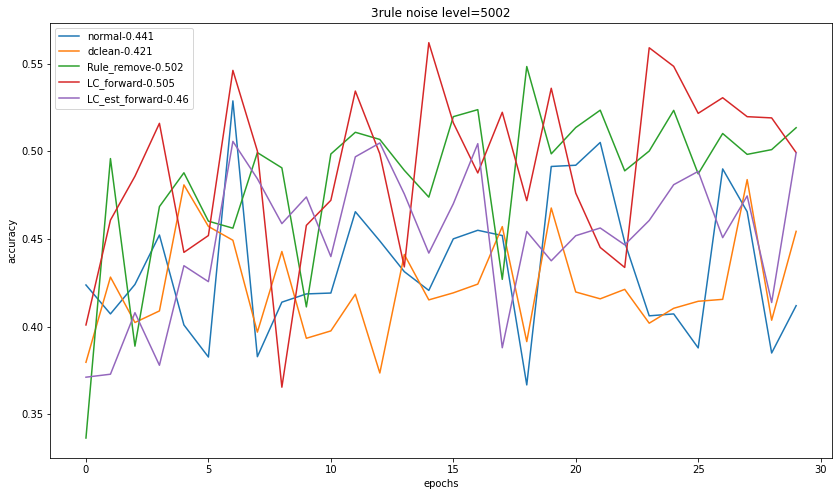

In [20]:
roughModel_path=checkpoint_filepath+'noiseLevel'+noise_level_str+'_testAcc'+acc_well_model
is_sort=0
range_epochs=epochs_plot

k_top=20
n_batch_modelt=250
lr_w =0.4
i_run=0

normal_history_name=roughModel_path+'/normal_history_'+str(i_run)
t=np.load(normal_history_name+'.npz',allow_pickle=True)['arr_0']
normal_history=np.array(dict(t.flatten()[0])['val_accuracy'])

dclean_filename=roughModel_path+'/dclean_'+str(i_run)
t=np.load(dclean_filename+'.npz',allow_pickle=True)['arr_0']
dclean_history=np.array(dict(t.flatten()[0])['val_accuracy'])

lc_history_name=roughModel_path+'/LC_forward_history'+str(i_run)
t=np.load(lc_history_name+'.npz',allow_pickle=True)['arr_0']
LC_forward_history=np.array(dict(t.flatten()[0])['val_accuracy'])

lc_history_name=roughModel_path+'/LC_est_forward_history'+str(i_run)
t=np.load(lc_history_name+'.npz',allow_pickle=True)['arr_0']
LC_est_forward_history=np.array(dict(t.flatten()[0])['val_accuracy'])

rule_remove_filename=roughModel_path+'/rule_remove_'+rule_code+str(i_run)
t=np.load(rule_remove_filename+'.npz',allow_pickle=True)['arr_0']
Rule_remove_history=np.array(dict(t.flatten()[0])['val_accuracy'])
"""
rule_weight_filename=roughModel_path+'/rule_weight_lr_w'+str(lr_w)+'_n_batch_modelt'+str(n_batch_modelt)+rule_code+'_'+str(i_run)
rule_weight_history=np.load(rule_weight_filename+'history.npz',allow_pickle=True)['arr_1']
rule_weight_history=rule_weight_history[:,1]
"""

t=np.arange(range_epochs)
plt.figure(figsize=(14,8))
plt.plot(
    t,normal_history[:range_epochs],
    t,dclean_history[:range_epochs],
         #t,rule_weight_history[:range_epochs],
         t,Rule_remove_history[:range_epochs],
         t,LC_forward_history[:range_epochs],
         t,LC_est_forward_history[:range_epochs]
         )
if is_sort:
    normal_history.sort()
    dclean_history.sort()
    #rule_weight_history.sort()
    Rule_remove_history.sort()
    LC_forward_history.sort()
    LC_est_forward_history.sort()
label=[
       'normal'+'-'+str(np.round(np.mean(normal_history[-k_top:-1]),3)),
       'dclean'+'-'+str(np.round(np.mean(dclean_history[-k_top:-1]),3)),
       #'rule_weight'+'-'+str(np.round(np.mean(rule_weight_history[-k_top:-1]),3)),
       'Rule_remove'+'-'+str(np.round(np.mean(Rule_remove_history[-k_top:-1]),3)),
       'LC_forward'+'-'+str(np.round(np.mean(LC_forward_history[-k_top:-1]),3)),
       'LC_est_forward'+'-'+str(np.round(np.mean(LC_est_forward_history[-k_top:-1]),3)),
       ]
plt.legend(labels=label)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('3rule noise level='+noise_level_str)
plt.savefig(roughModel_path)
i_run=0
range_epochs=epochs_plot

print(str(np.round(np.mean(normal_history[-k_top:-1]),3)))
print(str(np.round(np.mean(dclean_history[-k_top:-1]),3)))
print(str(np.round(np.mean(LC_forward_history[-k_top:-1]),3)))
print(str(np.round(np.mean(LC_est_forward_history[-k_top:-1]),3)))
print(str(np.round(np.mean(Rule_remove_history[-k_top:-1]),3)))

for lr_w in [0.02,0.1,0.4]:
    for n_batch_modelt in [50]:
        rule_weight_filename=roughModel_path+'/rule_weight_lr_w'+str(lr_w)+'_n_batch_modelt'+str(n_batch_modelt)+rule_code+'_'+str(i_run)
        rule_weight_history=np.load(rule_weight_filename+'history.npz',allow_pickle=True)['arr_1']
        rule_weight_history=rule_weight_history[:,1]
        
        #plt.plot(t,rule_weight_history[:range_epochs])
        rule_weight_history.sort()
        print(str(np.round(np.mean(rule_weight_history[-k_top:-1]),3)))
"""
for lr_w in [0.1]:
    for n_batch_modelt in [150,250]:
        rule_weight_filename=roughModel_path+'/rule_weight_lr_w'+str(lr_w)+'_n_batch_modelt'+str(n_batch_modelt)+rule_code+'_'+str(i_run)
        rule_weight_history=np.load(rule_weight_filename+'history.npz',allow_pickle=True)['arr_1']
        rule_weight_history=rule_weight_history[:,1]
        
        #plt.plot(t,rule_weight_history[:range_epochs])
        rule_weight_history.sort()
        print(str(np.round(np.mean(rule_weight_history[-k_top:-1]),3)))
"""


0.784
0.761
0.784
0.785
0.791
0.785
0.79
0.791
0.781
0.795


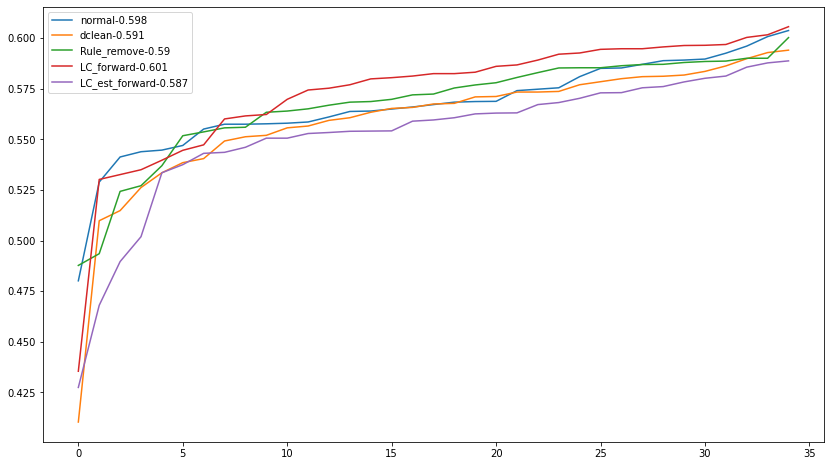

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(
    t,normal_history[:range_epochs],
    t,dclean_history[:range_epochs],
         #t,rule_weight_history[:range_epochs],
         t,Rule_remove_history[:range_epochs],
         t,LC_forward_history[:range_epochs],
         t,LC_est_forward_history[:range_epochs]
         )
label=[
       'normal'+'-'+str(np.round(np.mean(normal_history[-k_top:-1]),3)),
       'dclean'+'-'+str(np.round(np.mean(dclean_history[-k_top:-1]),3)),
       #'rule_weight'+'-'+str(np.round(np.mean(rule_weight_history[-k_top:-1]),3)),
       'Rule_remove'+'-'+str(np.round(np.mean(Rule_remove_history[-k_top:-1]),3)),
       'LC_forward'+'-'+str(np.round(np.mean(LC_forward_history[-k_top:-1]),3)),
       'LC_est_forward'+'-'+str(np.round(np.mean(LC_est_forward_history[-k_top:-1]),3)),
       ]
plt.legend(labels=label)

In [ ]:
range_calculate=[15,35]
print(np.mean(normal_history[range_calculate[0]:range_calculate[1]])),
#print(np.mean(rule_weight_history[range_calculate[0]:range_calculate[1]])),
print(np.mean(Rule_remove_history[range_calculate[0]:range_calculate[1]])),
print(np.mean(LC_forward_history[range_calculate[0]:range_calculate[1]])),
print(np.mean(LC_est_forward_history[range_calculate[0]:range_calculate[1]]))

0.5816750019788742
0.594955000281334
0.5917149990797043
0.5713900029659271


##plot result multi i_run 1

In [ ]:
lr_w =0.1
i_run_list=[0,1]
n_batch_modelt=50
roughModel_path=checkpoint_filepath+'noiseLevel'+noise_level_str+'_testAcc'+acc_well_model
for i_run in i_run_list:
    rule_weight_filename=roughModel_path+'/rule_weight_lr_w'+str(lr_w)+'_n_batch_modelt'+str(n_batch_modelt)+rule_code+'_'+str(i_run)
    rule_weight_history=np.load(rule_weight_filename+'history.npz',allow_pickle=True)['arr_1']
    rule_weight_history=rule_weight_history[:,1]

    rule_remove_filename=roughModel_path+'/rule_remove_'+rule_code+str(i_run)
    t=np.load(rule_remove_filename+'.npz',allow_pickle=True)['arr_0']
    Rule_remove_history=np.array(dict(t.flatten()[0])['val_accuracy'])

    lc_history_name=roughModel_path+'/LC_est_forward_history'+str(i_run)
    t=np.load(lc_history_name+'.npz',allow_pickle=True)['arr_0']
    LC_est_forward_history=np.array(dict(t.flatten()[0])['val_accuracy'])

    lc_history_name=roughModel_path+'/LC_forward_history'+str(i_run)
    t=np.load(lc_history_name+'.npz',allow_pickle=True)['arr_0']
    LC_forward_history=np.array(dict(t.flatten()[0])['val_accuracy'])

    normal_history_name=roughModel_path+'/normal_history_0'
    t=np.load(normal_history_name+'.npz',allow_pickle=True)['arr_0']
    normal_history=np.array(dict(t.flatten()[0])['val_accuracy'])

##analize confusion matrix

In [ ]:
i_run=0
list_class=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
#y_train_noisy, P = noisify_with_P(y_train_raw, 10, N)
#plot_confusion_matrix(P, list_class)

Confusion matrix, without normalization


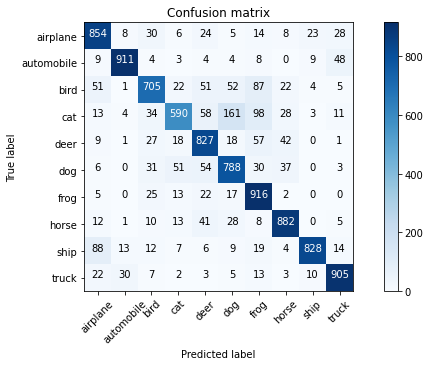

In [ ]:
normalModel_path=checkpoint_filepath+'v7/noiseLevel'+noise_level_str+'normal_'+str(i_run)

normalModel = cifar10resnetQ()
normalModel.model.load_weights(normalModel_path+'/normalModel')
pred_xTrain=normalModel.model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test_raw[:,0], pred_xTrain)
plot_confusion_matrix(cm, list_class)

Confusion matrix, without normalization


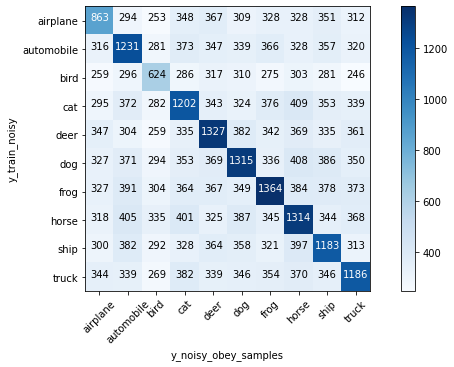

In [ ]:
cm = confusion_matrix(y_train_noisy[idx_obey_samples], Label_t_obey_samples.argmax(1))
plot_confusion_matrix(cm, list_class,
                      title='',
                      ylabel='y_train_noisy',
                      xlabel='y_noisy_obey_samples')

Confusion matrix, without normalization


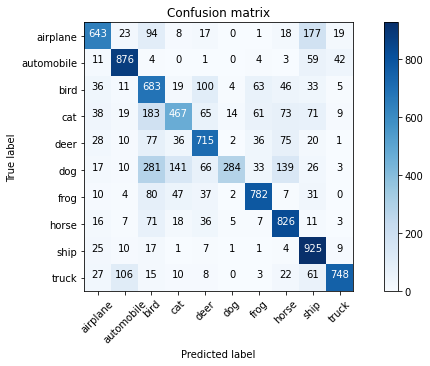

In [ ]:
rule_remove_filename=roughModel_path+'/rule_remove_'+rule_code+str(i_run)

lcModel = cifar10resnetQ()
lcModel.model.load_weights(rule_remove_filename+'/rule_remove_tmp')
pred_xTrain=lcModel.model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test_raw[:,0], pred_xTrain)
plot_confusion_matrix(cm, list_class)


rule_weight

Confusion matrix, without normalization
[[3312  310   67   24  213   36  154  232  273  379]
 [  10 4318    3    0   13   18   75   20   27  516]
 [ 347  118 1456   51  808  404 1223  417   89   87]
 [ 101   77   61  965  794  842 1056  702  134  268]
 [  64   22   17   15 3685   64  519  532   16   66]
 [  26   35   28   83  398 3129  366  736   33  166]
 [  24   39   18   17  185  123 4490   53   24   27]
 [  27   28   14   23  169   87  157 4389   13   93]
 [ 206  407   22    5   95   16  123   84 3699  343]
 [  55  182    6    2   24   14   57   85   25 4550]]


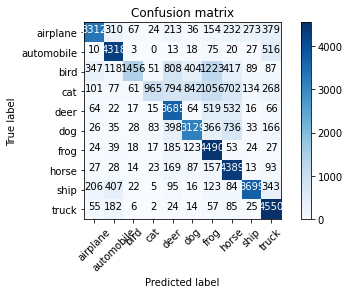

In [ ]:
lr_w=
n_batch_modelt=
rule_weight_filename=roughModel_path+'/rule_weight_lr_w'+str(lr_w)+'_n_batch_modelt'+str(n_batch_modelt)+rule_code+'_'+str(i_run)

Model_t = cifar10resnetQ()
Model_t.model.load_weights(rule_weight_filename+'/rule_weight_tmp')
pred_xTrain=Model_t.model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_train_raw, pred_xTrain)
plot_confusion_matrix(cm, list_class)
cm = confusion_matrix(y_train_noisy, pred_xTrain)
plot_confusion_matrix(cm, list_class)


In [ ]:
lcModel_path=checkpoint_filepath+'v7/noiseLevel'+noise_level_str+'_'+loss+str(i_run)

lcModel = cifar10resnetQ()
lcModel.model.load_weights(lcModel_path+'/lcModel')
pred_xTrain=lcModel.model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_train_raw, pred_xTrain)
plot_confusion_matrix(cm, list_class)
cm = confusion_matrix(y_train_noisy, pred_xTrain)
plot_confusion_matrix(cm, list_class)

In [ ]:
lcModel_path=checkpoint_filepath+'v7/noiseLevel'+noise_level_str+'est_'+loss+str(i_run)

lcModel = cifar10resnetQ()
lcModel.model.load_weights(lcModel_path+'/lcModel')
pred_xTrain=lcModel.model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_train_raw, pred_xTrain)
plot_confusion_matrix(cm, list_class)
cm = confusion_matrix(y_train_noisy, pred_xTrain)
plot_confusion_matrix(cm, list_class)

#.

#.

#remove on terminal (not draf)

#make noisy label

##create noisy label by the prediction of model 

###train a model and create label noise

In [ ]:
tf.random.set_seed(123)
well_model = cifar10resnetQ()
t=well_model.model.fit(X, to_categorical(Y, 10),batch_size=152,
              epochs=1)#,callbacks=[saveModelEpochAcc()]
acc_well_model=str(t.history['accuracy'][0])[2:5]
acc_well_model

395/395 [==============================] - 12s 26ms/step - loss: 1.8250 - accuracy: 0.3935


'486'

###load available model

In [ ]:
acc_well_model='689_678_1481' #874_839   689_678_1481  788_766
well_model = cifar10resnetQ()
well_model.model.load_weights(checkpoint_filepath+acc_well_model+'/weight')

In [ ]:
#scores = well_model.model.evaluate(x_train,y_train_raw,batch_size=512)
#trainAcc_well=str(np.round(scores[1],3))[2:5]
#print(trainAcc_well)
scores = well_model.model.evaluate(x_test,y_test,batch_size=512)
testAcc_well=str(np.round(scores[1],3))[2:5]
print(testAcc_well)

##change threshold

In [ ]:
(x_train, y_train_raw), (x_test, y_test_raw) = cifar10.load_data()
X=np.concatenate((x_train, x_test), axis=0)
Y=np.concatenate((y_train_raw, y_test_raw), axis=0)
Y=Y[:,0]
# normalize data.
X = X.astype('float32') / 255
# if subtract pixel mean is enabled
x_mean = np.mean(X, axis=0)
X -= x_mean
np.savez(checkpoint_filepath+'savez_data/full_preprocessed_img', X, Y)


170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
from sklearn.model_selection import train_test_split
random_state_split=3
x_train,x_test, y_train_raw, y_test_raw, idx_train, idx_test= train_test_split(X, Y, 
                                                          np.arange(60000),test_size=1/6,
                                                          shuffle=True, random_state=random_state_split)
pred_train_1hot = well_model.model.predict(x_train)
pred_train = pred_train_1hot.argmax(axis=1)

In [ ]:
#10%: acc_well_model:874_839 rand_state=3 thread_noise= 0.435 <=> (871 3 507);  (871 2 507);(871 1 507)
#20%: (754 3 37);  (754 2 37);(754 1 368)
#30%: (692 3 303);  (692 2 302);(692 1 303)
#40%: (449 3 3157);  (449 2 316);(449 1 3155)
#50%: (486 3 406);  (486 2 407);(486 1 407)
thread_noise=0.406 #0.288 =0.10 #0.4 =12.74  #0.48 = 10.52   #0.495  = 10.07 #0.7 =5.02   #0.9 =1.5   
idx_noise=[]
y_train_noisy=np.array(y_train_raw) #verified that it clone, not shallow
for i in range(n_train_samples):
    if pred_train[i]!=y_train_raw[i]:
        if pred_train_1hot[i,pred_train[i]]>thread_noise:
            #if is_obey_is_vehicle_sample(pred_train[i],is_vehicle[i]):
                #if is_obey_is_fly_sample(pred_train[i],is_fly[i]):
                    #if is_obey_is_onroad_sample(pred_train[i],is_onroad[i]):
            y_train_noisy[i]=pred_train[i]
            idx_noise.append(i)

print('noise level',len(idx_noise)/n_train_samples)
#verify
noise_level=np.count_nonzero(y_train_noisy!=y_train_raw)/n_train_samples
noise_level=np.round(noise_level,4)
noise_level_str=str(noise_level)[2:5]
print('noise level',noise_level)
#if (is_obey_vector(y_train_noisy,is_vehicle)):
#    print('every thing is ok')

noise level 0.50042
noise level 0.5004


In [ ]:
noise_level_str=noise_level_str+str(random_state_split)
if (os.path.exists(checkpoint_filepath+'savez_data/')==False):
    os.mkdir(checkpoint_filepath+'savez_data/')
np.savez(checkpoint_filepath+'savez_data/levelNoise'+noise_level_str+'_acc_well'+acc_well_model, idx_train, idx_test,y_train_noisy)

noise 0%

In [ ]:
from sklearn.model_selection import train_test_split
random_state_split=2
x_train,x_test, y_train_raw, y_test_raw, idx_train, idx_test= train_test_split(X, Y, 
                                                          np.arange(60000),test_size=1/6,
                                                          shuffle=True, random_state=random_state_split)
if (os.path.exists(checkpoint_filepath+'savez_data/')==False):
    os.mkdir(checkpoint_filepath+'savez_data/')
np.savez(checkpoint_filepath+'savez_data/levelNoise0'+str(random_state_split)+'_acc_well100', idx_train, idx_test,y_train_raw)

##symmetric T

In [ ]:
N=0.5
y_train_noisy, P = noisify_with_P(y_train_raw, 10, N)

Actual noise 0.50


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_raw, y_train_noisy)
cm
#plot_confusion_matrix(cm, list(range(10)))
#np.savez(work_path+'/pred_train',pred_train)
#np.savez(work_path+'/confusion_matrix_train',cm)

array([[2500,  267,  291,  271,  271,  306,  262,  283,  267,  282],
       [ 283, 2446,  290,  287,  310,  275,  266,  268,  273,  302],
       [ 295,  271, 2526,  278,  291,  247,  278,  242,  293,  279],
       [ 298,  272,  270, 2468,  284,  298,  275,  279,  263,  293],
       [ 298,  273,  268,  305, 2453,  295,  276,  285,  262,  285],
       [ 250,  291,  261,  297,  289, 2499,  254,  273,  274,  312],
       [ 273,  281,  313,  264,  287,  288, 2494,  254,  275,  271],
       [ 256,  307,  257,  291,  286,  258,  261, 2478,  313,  293],
       [ 264,  269,  288,  264,  283,  285,  289,  285, 2504,  269],
       [ 307,  274,  269,  258,  260,  292,  266,  292,  310, 2472]])

#draf

##compare normal and rule remove

In [ ]:
normalModel = cifar10resnetQ()
i_run=0
normalModel_path=checkpoint_filepath+'v7/noiseLevel'+noise_level_str+'normal_'+str(i_run)
normal_history_name=roughModel_path+'/normal_history_'+str(i_run)
normalModel.model.load_weights(normalModel_path+'/normalModel')
Model_t2 = cifar10resnetQ()
rule_remove_filename=roughModel_path+'/rule_remove_'+rule_code+str(i_run)
Model_t2.model.load_weights(rule_remove_filename+'/rule_remove_tmp')
p1=normalModel.model.predict(x_test).argmax(axis=1)
p2=Model_t2.model.predict(x_test).argmax(axis=1)
print(np.count_nonzero(p1!=y_test_raw)/10000)
print(np.count_nonzero(p2!=y_test_raw)/10000)

0.4219
0.42


Confusion matrix, without normalization


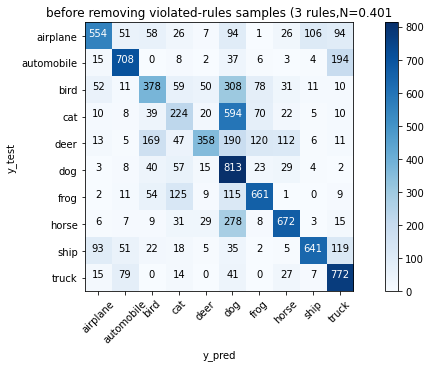

In [ ]:
cm = confusion_matrix(y_test_raw, p1)
plot_confusion_matrix(cm, list_class,
                      title='before removing violated-rules samples (3 rules,N='+str(N),
                      ylabel='y_test',
                      xlabel='y_pred')

Confusion matrix, without normalization


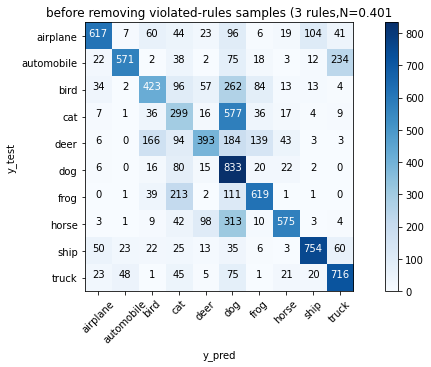

In [ ]:
cm = confusion_matrix(y_test_raw, p2.argmax(axis=1))
plot_confusion_matrix(cm, list_class,
                      title='before removing violated-rules samples (3 rules,N='+str(N),
                      ylabel='y_test',
                      xlabel='y_pred')

In [ ]:
normalModel.model.evaluate(x_test,y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.6130 - accuracy: 0.5756


[1.6297798156738281, 0.5746999979019165]

In [ ]:
Model_t2.model.evaluate(x_test,y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.3687 - accuracy: 0.5989


[1.3865023851394653, 0.5974000096321106]

##Rule_weight deal with out of RAM

In [ ]:
#270121 : start change to train on batch instead of fit because it isn't work

if (run_Rule):
    continu=0
    n_batch_modelt_list=[50]#[50,150,250]
    epochs=epochs_plot

    for lr_w in [0.02,0.1,0.4]:#[0.02,0.1,0.4]
        for n_batch_modelt in n_batch_modelt_list:
            for i_run in i_run_list:
                tf.random.set_seed(i_run)
                rule_weight_filename=roughModel_path+'/rule_weight_lr_w'+str(lr_w)+'_n_batch_modelt'+str(n_batch_modelt)+rule_code+'_'+str(i_run)

                print(str(lr_w)+'_'+str(n_batch_modelt))
                Model_t = cifar10resnetQ()
                #Model_t.model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3),metrics=['accuracy'])
                
                if (os.path.exists(rule_weight_filename)&(continu==1)):
                    d=np.load(rule_weight_filename+'history.npz',allow_pickle=True)
                    eps,val_history=d['arr_0'],d['arr_1'].tolist()
                    print('continue at epoch: '+str(len(val_history)))
                    Model_t.model.load_weights(rule_weight_filename+'/rule_weight_tmp')
                    epochs=epochs-len(val_history)
                else: #include case: avaiable model & force_run_again=1 & continu=0
                    eps=np.ones(n_train_samples)
                    val_history=[]
                
                mb_rule=batch_size_modelt*n_batch_modelt
                steps_per_epoch=n_train_samples//mb_rule
                period_val=steps_per_epoch
                T=int(epochs*steps_per_epoch+1)
                for t in range(0,T):
                    idx_mb=np.random.choice(n_train_samples,mb_rule,replace=False)
                    Xt=x_train[idx_mb]
                    Yt=whole_Yt[idx_mb]
                    Label_t=whole_Label_t[idx_mb]
                    Dt=np.nonzero(whole_Dt[idx_mb])[0]#a mask(t=1 inplace of violated sample)
                    if (Dt.shape[0]!=0):
                        pred=K.variable(Model_t.model.predict(Xt[Dt]))
                        K_cate_loss=tf.constant(K.categorical_crossentropy(K.variable(Label_t[Dt]), pred),dtype=float)
                        #e=tf.convert_to_tensor(eps[Dt],dtype=float)
                        e=tf.Variable(eps[idx_mb[Dt]],dtype=float)
                        with tf.GradientTape(persistent=False) as tape:
                            #Loss=tf.keras.losses.CategoricalCrossentropy()
                            #loss=Loss(Label_t,Model_t_pred,sample_weight=eps)
                            loss=tf.math.reduce_sum(tf.math.multiply(e,K_cate_loss))
                        gt=tape.gradient(loss,e).numpy()
                        #print(tf.math.reduce_max(gt))
                        tmp=eps[idx_mb[Dt]]-lr_w*gt
                        eps[idx_mb[Dt]]=(tmp>0)*tmp
                        del e,loss,gt,Yt,K_cate_loss,tape,pred,tmp
                        K.clear_session()
                    datagen.fit(Xt)
                    Model_t.model.fit(
                        x=datagen.flow(Xt, Label_t, batch_size=batch_size_modelt,sample_weight=eps[idx_mb]),
                        #steps_per_epoch=n_train_samples // batch_size,
                        epochs=1,verbose=0)
                    if(t %period_val==0):
                        val_history.append(Model_t.model.evaluate(x_test,y_test_1hot,verbose=1))
                        np.savez(rule_weight_filename+'history',eps,np.array(val_history))
                        if (os.path.exists(rule_weight_filename)==False):
                            os.mkdir(rule_weight_filename)
                        Model_t.model.save_weights(rule_weight_filename+'/rule_weight_tmp')
                t=np.array(val_history)
                t.sort
                np.round(np.mean(t[-5:-1]),3)


0.02_50
313/313 [==============================] - 1s 4ms/step - loss: 0.9839 - accuracy: 0.7672
0.1_50
313/313 [==============================] - 1s 5ms/step - loss: 0.7824 - accuracy: 0.8067
0.4_50
313/313 [==============================] - 1s 4ms/step - loss: 0.8160 - accuracy: 0.8063


"\n\n\n\n\n    Model_t.model.fit(Xt, Label_t.astype(float),sample_weight=eps[idx_mb],\n                              validation_data=(x_test,y_test_1hot),batch_size=batch_size_modelt,\n                              epochs=1,verbose=2,validation_freq=1,use_multiprocessing=True)\n    print(K.get_value(Model_t.model.optimizer.lr))\n    Model_t.model.save_weights(roughModel_path+'/Model_t_tmp')\n    if(t %period_val==0):\n        print(history)\n        pred_test = Model_t.model.predict(x_test).argmax(axis=1)\n        acc_test=np.count_nonzero(pred_test==y_test_raw[:,0])/10000\n        print(acc_test)\n        "

##explore violated samples

In [ ]:
roughModel_weight_name='/content/gdrive/MyDrive/Drive nguyendinhquoc312/LAB/Nakajo_labelNoise/code/cifar10/resnet_proposedAlgo/output/tmp_model/rough_2rule/noiseLevelN_0.2_testAccN_/roughModel_validationIsClean_794_818'
roughModel.model.load_weights(roughModel_weight_name)
whole_Yt=roughModel.model.predict(x_train).argmax(axis=1)
whole_Label_t=to_categorical(y_train_noisy, 10).astype(float)
whole_Dt=RuleCheck_YtLabelt_whole(whole_Yt)

number of wrong prediction: 17186
number violated samples: 4940


In [ ]:
diff=(whole_Yt==y_train_noisy)
print('number of wrong prediction:',np.count_nonzero(diff))
rule1=list(map(is_obey_is_vehicle_sample,whole_Yt,is_vehicle))
rule2=list(map(is_obey_is_fly_sample,whole_Yt,is_fly))
rule3=list(map(is_obey_is_onroad_sample,whole_Yt,is_onroad))
violated_rule= ~ (np.array(rule1) & np.array(rule2)& np.array(rule3))
print('number violated samples:',np.count_nonzero(violated_rule))

number of wrong prediction: 7850
number violated samples: 32581


In [ ]:
plot_confusion_matrix(P, list_class,
                      title='before removing violated-rules samples (3 rules,N='+str(N),
                      ylabel='y_train_raw',
                      xlabel='y_train_noisy')

NameError: ignored

Confusion matrix, without normalization


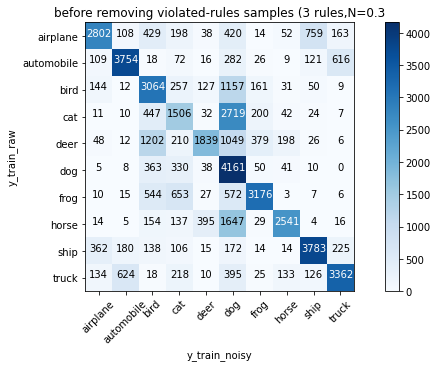

In [ ]:
cm = confusion_matrix(y_train_raw, y_train_noisy_raw)
plot_confusion_matrix(cm, list_class,
                      title='before removing violated-rules samples (3 rules,N='+str(N),
                      ylabel='y_train_raw',
                      xlabel='y_train_noisy')

In [ ]:
Dt

array([   18,    42,    47, ..., 49987, 49995, 49997])

In [ ]:
eps

array([1, 1, 1, ..., 0, 1, 1])

Confusion matrix, without normalization


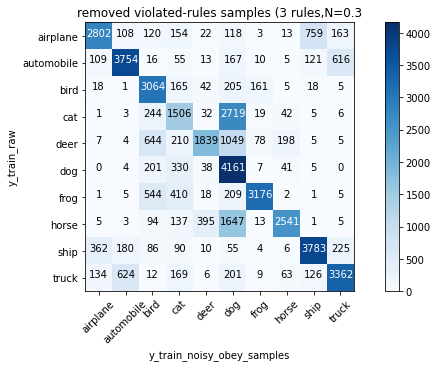

In [ ]:
Dt=np.nonzero(whole_Dt)[0]#a mask(t=1 inplace of violated sample)
eps=np.ones(n_train_samples,dtype=int)
eps[Dt]=0
idx_obey_samples=np.nonzero(eps)[0]
x_train_obey_samples=x_train[idx_obey_samples]
y_train_noisy_obey_samples=y_train_noisy_raw[idx_obey_samples]

cm = confusion_matrix(y_train_raw[idx_obey_samples], y_train_noisy_obey_samples)
plot_confusion_matrix(cm, list_class,
                      title='removed violated-rules samples (3 rules,N='+str(N),
                      ylabel='y_train_raw',
                      xlabel='y_train_noisy_obey_samples')

Confusion matrix, without normalization


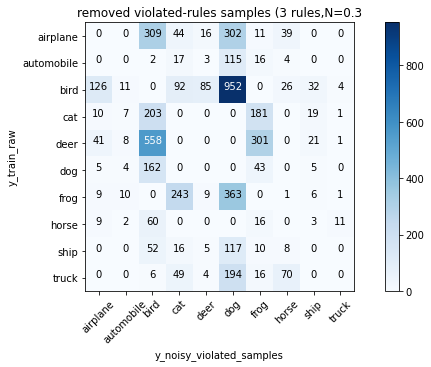

In [ ]:
y_noisy_violated_samples=y_train_noisy_raw[Dt]
cm = confusion_matrix(y_train_raw[Dt], y_noisy_violated_samples)
plot_confusion_matrix(cm, list_class,
                      title='removed violated-rules samples (3 rules,N='+str(N),
                      ylabel='y_train_raw',
                      xlabel='y_noisy_violated_samples')